<a href="https://colab.research.google.com/github/shabansatti/Global-Controller-for-Transient-Stability-and-Voltage-Regulation/blob/main/Global_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
#@title Modules List
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pdb

In [76]:
#@title Given Generator Parameters
sys_parameters={
    "H" : 4,
    "D" : 5,
    "w0" : 314.157,
    "Td0_t" : 6.9,
    "xL" : 0.4853,        # Line reactance
    "xd" : 1.863,         # Direct axis Synchronous Reactance
    "xd_t" : 0.257,       # Direct axis Transient Reactance
    "xT" : 0.127,         # Transformer Reactance
    "Kc" : 1             # Constant Kc
 }

In [77]:
#@title Given Initial Conditions
init_conditions = {
    "angle": 72*pi/180,        # Rotor Angle
    "Vt0" : 1.0,              # Terminal Voltage
    "Pm" : 0.90,           # Mechanical Power
    "w_0" : 314.159,
    "del_Vt": 0
    }

In [78]:
#@title SMIB Class
class SMIB:
  def __init__ (self,parameters,initial_conditions):
    self.pr=parameters;
    self.ic=initial_conditions;
    self.xT  = self.pr["xT"];
    self.xL  = self.pr["xL"];
    self.xd_t= self.pr["xd_t"]
    self.xd= self.pr["xd"]
    self.xs  = self.pr["xT"]+self.pr["xL"]/2;
    self.xds = self.pr["xd"]+self.pr["xT"]+self.pr["xL"]/2;     # Pre_Fault Total Synchronous Reactance
    self.xds_t=self.pr["xd_t"]+self.pr["xT"]+self.pr["xL"]/2;   # Total Transient Reactance
    self.T_t= self.xds_t*self.pr["Td0_t"]/self.xds;           # Transient Time Constant
    self.Pe0=self.ic["Pm"];
    self.Pm=self.ic["Pm"];
    self.Vt0=self.ic["Vt0"];
    self.del_Vt=self.ic["del_Vt"];
    self.w_0=self.ic["w_0"];


  def init_variables(self):
    # Calculate Vs
    a1=2*self.xs*self.pr["xd"]*self.Pe0*self.xds/(
        sin(self.ic["angle"]))-2*self.xs*self.pr["xd"]*self.xds*self.Pe0*(
            1/tan(self.ic["angle"]))+pow((self.xds*self.Vt0),2);
    #print("angle",self.ic["angle"])
    a=sqrt(a1);
    #print(" a1", a1)
    b=self.pr["xd"];
    c=(sin(self.ic["angle"]))/(self.xs*self.Pe0*self.xds);
    #print("c",c)
    #print("p",pow((a/b),2)-(4/(b*c)))
    vs1=((a/b)+sqrt(pow((a/b),2)-(4/(b*c))))/2;
    vs2=((a/b)-sqrt(pow((a/b),2)-(4/(b*c))))/2;
    print("vs1",vs1)
    print("vs2",vs2)
    self.Vs=sqrt(pow((vs1.real),2)+pow((vs1.imag),2));

    # Calculate Eq
    self.Eq0=self.Pe0*self.xds/(self.Vs*sin(self.ic["angle"]));
    self.Ef0=self.Eq0;
    self.Eq=self.Eq0
    # Calculate Eq_hat
    self.Eq_hat0=(self.Eq0+(self.pr["xd"]-self.pr["xd_t"])*self.Vs*
     (cos(self.ic["angle"]))/self.xds_t)*(self.xds_t/self.xds);
    self.Vs
    self.states=np.array([self.ic["angle"], self.w_0, self.Eq_hat0, self.del_Vt])
    #print(self.states)
    return self.states

In [79]:
#@title Child Class Dynamics
class dynamics(SMIB):
  def __init__(self,parameters,initial_conditions,T, trans_cont,volt_cont, alpha_t, alpha_v):
    super().__init__(parameters,initial_conditions);
    self.t=T;
    self.Kt=trans_cont;
    self.Kv=volt_cont;
    self.alpha_t=alpha_t;
    self.alpha_v=alpha_v;


  def star_delta(self, XA, XB, XC):
    X1 = XA+XC+XA*XC/XB; # X1 is between terminals A & C
    X2 = XA+XB+XA*XB/XC; # X2 is between terminals A & B
    X3 = XB+XC+XB*XC/XA; # X3 is between terminals B & C
    return X2

  def fault_reactance(self, ratio, fL):
    # Outputs Fault x_f(1) & Post Fault x_f(2) Reactance %
    x_temp = self.star_delta(self.xd_t+self.xT,self.xL,ratio*self.xL);
    x_f0 = x_temp;         # Fault Reactance
    # Post-Fault Reactance
    x_f1=self.xd+self.xT+self.xL*(2-fL)/2;  # Post Fault Reactance
    return [x_f0,x_f1]




  def mod_euler_solver(self,tot_imp,cont_type,del_Pm):

    sys_d = self.state_derivatives(tot_imp,cont_type,del_Pm);            # Der.Cal. using current last time step values
    sys_temp = self.states;
    #print(self.states);
    #print((sys_d)*(self.t)/2);
    self.states+= sys_d*self.t;                       # Prediction Step\

    sys_dp=self.state_derivatives(tot_imp,cont_type,del_Pm);             # Der. Cal. using Prediction


    self.states=sys_temp + (sys_dp+sys_d)*(self.t)/2;   # Correction Step
    #print(self.states[0])
    return np.array([self.states[0],self.states[1],self.Vs*self.Eq*(sin(self.states[0]))/tot_imp,self.Vt0+self.states[3]])

  def state_derivatives(self,x,cont_type,del_pm):


    Eq=(self.xds/self.xds_t)*self.states[2]-(
        self.pr["xd"]-self.pr["xd_t"])*self.Vs*(cos(self.states[0]))/self.xds_t;
    #print("diff",Eq-self.Eq0)
    Pe=self.Vs*Eq*(sin(self.states[0]))/x;
    cont=np.array([self.states[0]-self.ic["angle"], self.states[1]-self.ic["w_0"], Pe-self.Pm-del_pm, self.states[3]]);
    #vf=1;
    if (cont_type=="Pre-Fault"):
      uf=self.Ef0;
      K=[0, 0, 0, 0];
      vf=0;
    elif (cont_type=="Transient"):
      K=self.Kt;
      vf=np.matmul(K,np.atleast_2d(cont).T)
      vf=vf[0];
    elif (cont_type=="Voltage"):
      K=self.Kv;
      vf=np.matmul(K,np.atleast_2d(cont).T)
      vf=vf[0];
    elif(cont_type=="Global"):
      z=sqrt(alpha_t*pow(self.states[1],2)+alpha_v*pow(self.states[3],2))
      mu=(1-1/(1+exp(-120*(z-0.08))))*(1/(1+exp(-120*(z+0.08))));
      md=1-mu;
      vf_t=np.matmul(self.Kt,np.atleast_2d(cont).T)
      vf_t=vf_t[0];
      vf_v=np.matmul(self.Kv,np.atleast_2d(cont).T)
      vf_v=vf_v[0];
      vf=mu*vf_t+md*vf_v;

    if(cont_type!="Pre-Fault"):
      #uf=(self.xds_t/(self.Vs*sin(self.states[0])))*(vf-self.T_t*self.Vs*Eq*(
          #(cos(self.states[0]*self.states[1]))/self.xds_t)+self.Pm)-self.pr["Td0_t"]*(
              #self.pr["xd"]-self.pr["xd_t"])*self.Vs*(sin(self.states[0]*self.states[1]))/self.xds_t;
      uf= (self.xds_t/(self.Vs*sin(self.states[0])))*(vf-self.pr["Td0_t"]*(
          self.states[2]*self.Vs*(cos(self.states[0]))/self.xds_t)*(
              self.states[1]-self.w_0)+self.Pm+del_pm)+(self.xd-self.xd_t)*(
                  self.states[2]-self.Vs*cos(self.states[0]))/self.xds_t
    Ef=self.pr["Kc"]*uf;
    Vt=self.Vt0+self.states[3];

    f1=-(pow(Pe,2)*pow(self.xs,2)*cos(self.states[0]))/(
        Vt*pow(self.Vs,2)*pow(sin(self.states[0]),3))-(
            self.xs*self.pr["xd_t"]*Pe)/(Vt*self.xds_t*pow((sin(self.states[0])),2));
    f2=(Pe*pow(self.xs,2))/(Vt*pow(self.Vs,2)*pow(sin(self.states[0]),2))+(
        self.xs*self.pr["xd_t"]*cos(self.states[0]))/(Vt*self.xds_t*(sin(self.states[0])));

    self.st_d=np.hstack((np.array(([self.states[1]-self.w_0])),
               np.array([-(self.pr["D"]/(2*self.pr["H"]))*(self.states[1]-self.w_0)-(
                  self.ic["w_0"]/(2*self.pr["H"]))*(Pe-self.Pm-del_pm)]), (Ef-Eq)/self.pr["Td0_t"],
                        f1*(self.states[1]-self.ic["w_0"])-f2*(Pe-self.Pm-del_pm)/self.pr["Td0_t"]+f2*vf/self.pr["Td0_t"]))
    #print(self.states[1]-self.ic["w_0"])
    #print(Pe-self.Pm)
    return self.st_d

In [80]:
#@title Function: Output Display
def display_output(states,time,step_size,plot_title):
  time=time*step_size;
  angle=states[:,0]
  speed=states[:,1]
  elec_power=states[:,2]
  voltage=states[:,3]

  plt.subplot(4,1,1)
  plt.plot(time, angle)
  plt.xlabel("Time")
  plt.ylabel("Rotor Angle")
  plt.title("Rotor Angle Graph ("+plot_title+" )")
  plt.show()

  plt.subplot(4,1,2)
  plt.xlabel("Time")
  plt.ylabel("Rotor Speed")
  plt.title("Rotor Speed Graph")
  plt.plot(time, speed)
  plt.show()
  plt.subplot(4,1,3)
  plt.xlabel("Time")
  plt.ylabel("Electrical Power")
  plt.title("Electrical Power Graph")
  plt.plot(time, elec_power)
  plt.show()
  plt.subplot(4,1,4)
  plt.xlabel("Time")
  plt.ylabel("Voltage")
  plt.title("Voltage Graph")
  plt.plot(time, voltage)
  plt.show()

vs1 1.000833341958629
vs2 0.41886388924885376


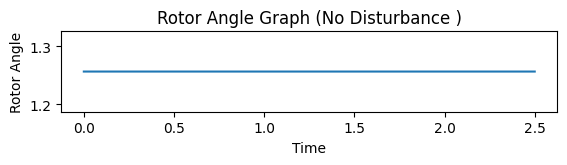

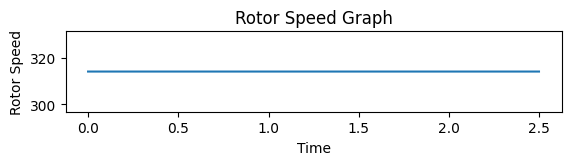

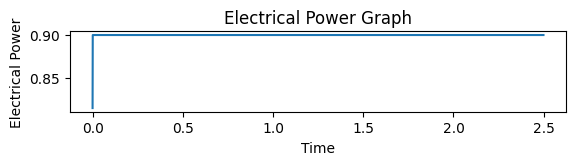

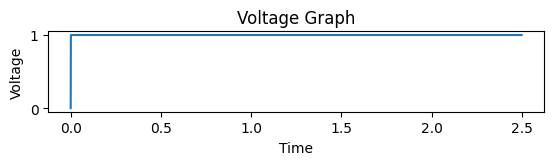

In [81]:
#@title No Fault Simulation
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
xds=2.23265;
end_time=2500;
nofault_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v)
states=nofault_sim.init_variables()
time=np.array([0])
for i in range(1,end_time,1):
  st_temp=nofault_sim.mod_euler_solver(xds,"Pre-Fault",0);
  #print(st_temp)
  #print(states)
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
display_output(states,time,step_size,"No Disturbance")

vs1 1.000833341958629
vs2 0.41886388924885376
['Angle', 'Speed', 'Power', 'Vt']
Initial Values : [  1.25663706 314.159        0.81498391] 1
Final Values : [  1.2746372  314.15989738   0.81639031  -1.37869127]


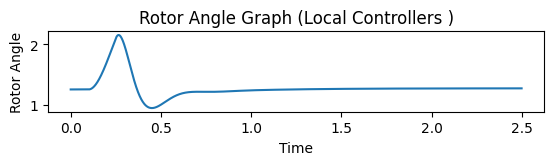

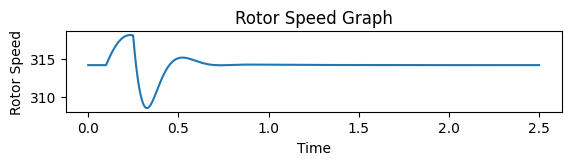

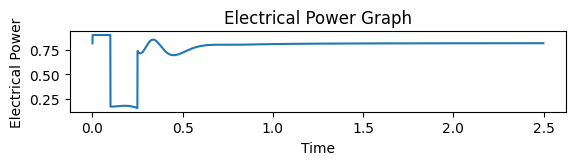

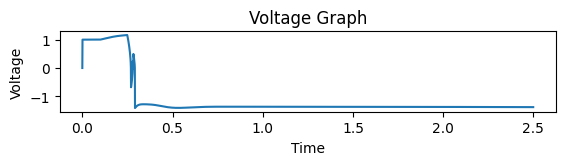

In [82]:
#@title Fault at 0.1 sec, Bus opened at 0.25 sec, switching at 1 sec
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
ratio=0.035;
fL=0;
fs_time=0.1;
ff_time=0.25;
sw_time=1;
xds=2.23265;
end_time=2500;
fault1_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v);
fault_imp= fault1_sim.fault_reactance(ratio, fL);
states=fault1_sim.init_variables();
time=np.array([0])
for i in range(1,end_time,1):
  if(i*step_size<fs_time):
    st_temp=fault1_sim.mod_euler_solver(xds,"Pre-Fault",0);
  elif (i*step_size>=fs_time and i*step_size<ff_time):
    st_temp=fault1_sim.mod_euler_solver(fault_imp[0],"Transient",0);
  elif (i*step_size>=ff_time and i*step_size<sw_time):
    st_temp=fault1_sim.mod_euler_solver(fault_imp[1],"Transient",0);
  elif (i*step_size>=sw_time):
    st_temp=fault1_sim.mod_euler_solver(fault_imp[1],"Transient",0);
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
print(["Angle","Speed","Power", "Vt"])
print("Initial Values :",states[0,0:3],1)
print("Final Values :",states[-1,:])
display_output(states,time,step_size, "Local Controllers")

vs1 1.000833341958629
vs2 0.41886388924885376
['Angle', 'Speed', 'Power', 'Vt']
Initial Values : [  1.25663706 314.159        0.81498391] 1
Final Values : [  1.00972416 314.21516011   0.72268811   1.00425631]


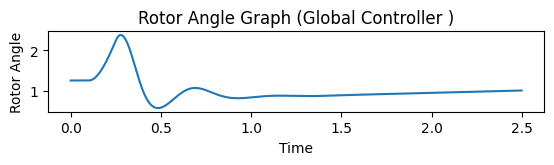

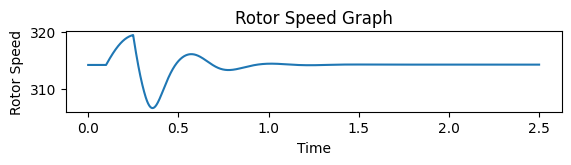

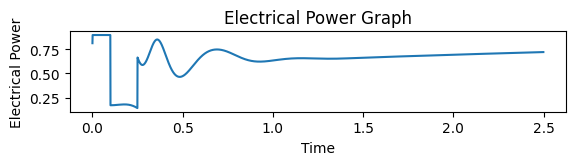

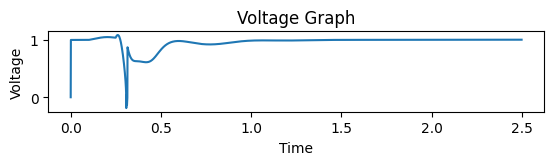

In [83]:
#@title Fault at 0.1 sec, Bus opened at 0.25 sec, Global Controller
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
ratio=0.035;
fL=0;
fs_time=0.1;
ff_time=0.25;
sw_time=1;
xds=2.23265;
end_time=2500;
fault1GL_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v);
fault_imp= fault1GL_sim.fault_reactance(ratio, fL);
states=fault1GL_sim.init_variables();
time=np.array([0])
for i in range(1,end_time,1):
  if(i*step_size<fs_time):
    st_temp=fault1GL_sim.mod_euler_solver(xds,"Pre-Fault",0);
  elif (i*step_size>=fs_time and i*step_size<ff_time):
    st_temp=fault1GL_sim.mod_euler_solver(fault_imp[0],"Global",0);
  elif (i*step_size>=ff_time and i*step_size<sw_time):
    st_temp=fault1GL_sim.mod_euler_solver(fault_imp[1],"Global",0);
  elif (i*step_size>=sw_time):
    st_temp=fault1GL_sim.mod_euler_solver(fault_imp[1],"Global",0);
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
print(["Angle","Speed","Power", "Vt"])
print("Initial Values :",states[0,0:3],1)
print("Final Values :",states[-1,:])
display_output(states,time,step_size, "Global Controller")

vs1 1.000833341958629
vs2 0.41886388924885376
['Angle', 'Speed', 'Power', 'Vt']
Initial Values : [  1.25663706 314.159        0.81498391] 1
Final Values : [  0.75234973 314.23215722   0.58327867   1.00242038]


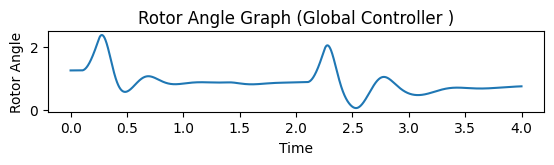

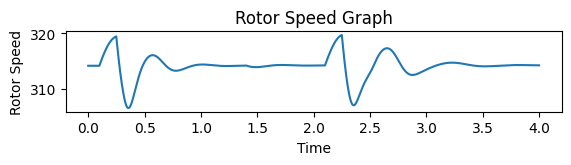

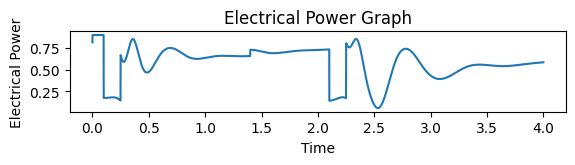

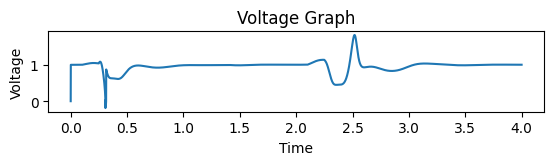

In [84]:
#@title Double Fault with restoration, Global Controller
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
ratio=0.035;
fL=0;
f1s_time=0.1;
f1f_time=0.25;
re_time=1.4;
f2s_time=2.1;
f2f_time=2.25;
sw_time=1;
xds=2.23265;
end_time=4000;
fault2_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v);
fault2_imp= fault2_sim.fault_reactance(ratio, fL);
states=fault2_sim.init_variables();
time=np.array([0])

for i in range(1,end_time,1):
  if(i*step_size<f1s_time):
    st_temp=fault2_sim.mod_euler_solver(xds,"Pre-Fault",0);
  elif (i*step_size>=f1s_time and i*step_size<f1f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[0],"Global",0);
  elif (i*step_size>=f1f_time and i*step_size<re_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[1],"Global",0);
  elif (i*step_size>=re_time and i*step_size<f2s_time):
    st_temp=fault2_sim.mod_euler_solver(2.23265,"Global",0);
  elif (i*step_size>f2s_time and i*step_size<f2f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[0],"Global",0);
  elif (i*step_size>=f2f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[1],"Global",0);
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
print(["Angle","Speed","Power", "Vt"])
print("Initial Values :",states[0,0:3],1)
print("Final Values :",states[-1,:])
display_output(states,time,step_size, "Global Controller")

vs1 1.000833341958629
vs2 0.41886388924885376
['Angle', 'Speed', 'Power', 'Vt']
Initial Values : [  1.25663706 314.159        0.81498391] 1
Final Values : [  1.27288496 314.1621509    0.81595256  -0.70531264]


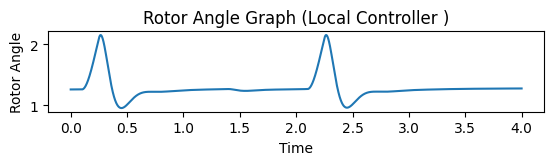

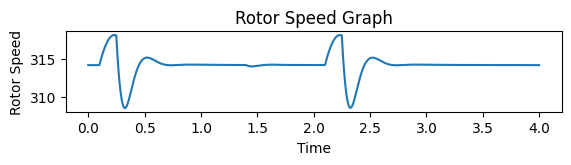

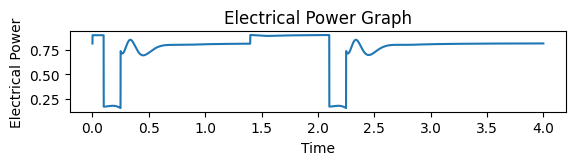

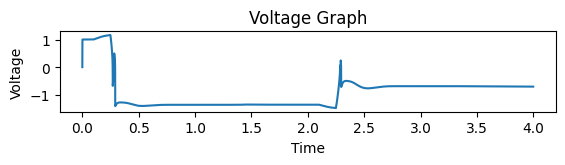

In [85]:
#@title Double Fault with restoration, Local Controller
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
ratio=0.035;
fL=0;
f1s_time=0.1;
f1f_time=0.25;
re_time=1.4;
f2s_time=2.1;
f2f_time=2.25;
sw_time=1;
xds=2.23265;
end_time=4000;
fault2_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v);
fault2_imp= fault2_sim.fault_reactance(ratio, fL);
states=fault2_sim.init_variables();
time=np.array([0])

for i in range(1,end_time,1):
  if(i*step_size<f1s_time):
    st_temp=fault2_sim.mod_euler_solver(xds,"Pre-Fault",0);
  elif (i*step_size>=f1s_time and i*step_size<f1f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[0],"Transient",0);
  elif (i*step_size>=f1f_time and i*step_size<re_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[1],"Transient",0);
  elif (i*step_size>=re_time and i*step_size<f2s_time):
    st_temp=fault2_sim.mod_euler_solver(2.23265,"Transient",0);
  elif (i*step_size>f2s_time and i*step_size<f2f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[0],"Transient",0);
  elif (i*step_size>=f2f_time):
    st_temp=fault2_sim.mod_euler_solver(fault2_imp[1],"Transient",0);
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
print(["Angle","Speed","Power", "Vt"])
print("Initial Values :",states[0,0:3],1)
print("Final Values :",states[-1,:])
display_output(states,time,step_size, "Local Controller")

vs1 1.000833341958629
vs2 0.41886388924885376
['Angle', 'Speed', 'Power', 'Vt']
Initial Values : [  1.25663706 314.159        0.81498391] 1
Final Values : [  1.25954309 314.19113109   0.8125374    1.00208171]


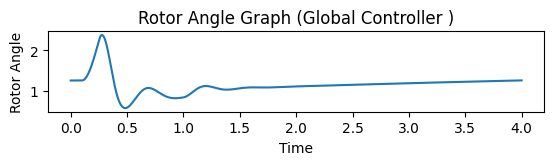

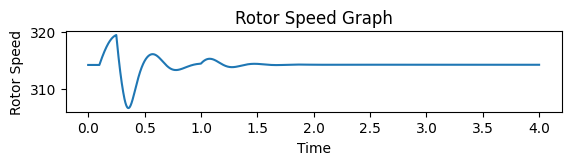

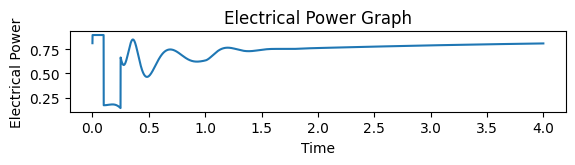

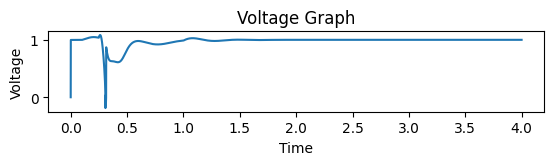

In [86]:
#@title Fault at 0.1 sec, Bus opened at 0.25 sec, Mech. Power increased by 30% Global Controller
step_size=0.001;
Kt= [22.36, 12.81, -82.45, 0];
Kv= [0, 10.11, -30.81, -40.14];
alpha_t=0.5;
alpha_v=0.5;
ratio=0.035;
fL=0;
fs_time=0.1;
ff_time=0.25;
sw_time=1;
xds=2.23265;
end_time=4000;
fault3GL_sim=dynamics(sys_parameters,init_conditions,step_size,Kt,Kv,alpha_t,alpha_v);
fault_imp= fault3GL_sim.fault_reactance(ratio, fL);
states=fault3GL_sim.init_variables();
time=np.array([0])
for i in range(1,end_time,1):
  if(i*step_size<fs_time):
    st_temp=fault3GL_sim.mod_euler_solver(xds,"Pre-Fault",0);
  elif (i*step_size>=fs_time and i*step_size<ff_time):
    st_temp=fault3GL_sim.mod_euler_solver(fault_imp[0],"Global",0);
  elif (i*step_size>=ff_time and i*step_size<sw_time):
    st_temp=fault3GL_sim.mod_euler_solver(fault_imp[1],"Global",0);
  elif (i*step_size>=sw_time):
    st_temp=fault3GL_sim.mod_euler_solver(fault_imp[1],"Global",0.27);
  states=np.row_stack((states,st_temp));
  time=np.row_stack((time,i));
print(["Angle","Speed","Power", "Vt"])
print("Initial Values :",states[0,0:3],1)
print("Final Values :",states[-1,:])
display_output(states,time,step_size, "Global Controller")